## Data Cleaning

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import coint
import warnings
warnings.filterwarnings('ignore')

# Load transit time data from all three sheets
xl_file = 'data/colonial_transit_time.xlsx'

# Read data from each sheet
line1_data = pd.read_excel(xl_file, sheet_name='line1')
line3_data = pd.read_excel(xl_file, sheet_name='line3') 
line13_data = pd.read_excel(xl_file, sheet_name='line13')

print("Data loaded successfully:")
print(f"Line 1: {len(line1_data)} records")
print(f"Line 3: {len(line3_data)} records") 
print(f"Line 13: {len(line13_data)} records")

# Display first few rows of each dataset
print("\n=== Line 1 Data Sample ===")
display(line1_data.head())
print(f"Columns: {line1_data.columns.tolist()}")

print("\n=== Line 3 Data Sample ===")
display(line3_data.head())
print(f"Columns: {line3_data.columns.tolist()}")

print("\n=== Line 13 Data Sample ===") 
display(line13_data.head())
print(f"Columns: {line13_data.columns.tolist()}")

Data loaded successfully:
Line 1: 78 records
Line 3: 48 records
Line 13: 373 records

=== Line 1 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2024-08-22,HTN,GBJ,46,8,7,7,7,8.291667
1,2024-08-26,HTN,GBJ,47,7,6,7,10,7.250000
2,2024-08-29,HTN,GBJ,48,8,18,9,10,8.750000
3,2024-09-04,HTN,GBJ,49,7,6,9,10,7.250000
4,2024-09-08,HTN,GBJ,50,8,23,9,18,8.958333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']

=== Line 3 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2025-01-15,GBJ,HTN,3,7.0,17.0,3.0,11.0,7.708333
1,2025-01-21,GBJ,HTN,4,8.0,6.0,3.0,4.0,8.250000
2,2025-01-26,GBJ,HTN,5,8.0,5.0,NaN,NaN,8.208333
3,2025-02-02,GBJ,HTN,6,7.0,3.0,3.0,5.0,7.125000
4,2025-02-05,GBJ,HTN,7,5.0,8.0,2.0,18.0,5.333333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']

=== Line 13 Data Sample ===


,Date,From,To,Cycle,Gas Days,Gas Hours,Distillates Days,Distillates Hours,Gas Transit Days
0,2020-07-01,HTN,LNJ,38,18,8,NaN,NaN,18.333333
1,2020-07-01,HTN,LNJ,39,18,5,NaN,NaN,18.208333
2,2020-07-01,HTN,LNJ,40,17,5,NaN,NaN,17.208333
3,2020-07-01,HTN,LNJ,41,17,22,NaN,NaN,17.916667
4,2020-07-01,HTN,LNJ,42,20,5,NaN,NaN,20.208333


Columns: ['Date', 'From', 'To', 'Cycle', 'Gas Days', 'Gas Hours', 'Distillates Days', 'Distillates Hours', 'Gas Transit Days']


## Step 1: Calculate Gas Transit Days

Converting the separate Gas Days and Gas Hours columns into a single decimal Gas Transit Days column for Line 1 and Line 3 data to match the Line 13 format. This will enable direct comparison across all three pipeline lines.

In [324]:
# Create Gas Transit Days column for Line 1 and Line 3 (similar to Line 13)
# Convert Gas Days + Gas Hours to decimal days
line1_data['Gas Transit Days'] = line1_data['Gas Days'] + line1_data['Gas Hours'] / 24
line3_data['Gas Transit Days'] = line3_data['Gas Days'] + line3_data['Gas Hours'] / 24

# Add year column for consistency
line1_data['Date'] = pd.to_datetime(line1_data['Date'])
line3_data['Date'] = pd.to_datetime(line3_data['Date'])
line13_data['Date'] = pd.to_datetime(line13_data['Date'])

line1_data['year'] = line1_data['Date'].dt.year
line3_data['year'] = line3_data['Date'].dt.year

print("Gas Transit Days calculated:")
display(line1_data['Gas Transit Days'].describe())
display(line3_data['Gas Transit Days'].describe())
display(line13_data['Gas Transit Days'].describe())

# Display sample with new column
print("\n=== Line 1 with Gas Transit Days ===")
display(line1_data[['Date', 'Gas Days', 'Gas Hours', 'Gas Transit Days', 'year']].head())

print("\n=== Line 3 with Gas Transit Days ===")
display(line3_data[['Date', 'Gas Days', 'Gas Hours', 'Gas Transit Days', 'year']].head())

Gas Transit Days calculated:


count    78.000000
mean      8.432692
std       0.803476
min       7.208333
25%       7.718750
50%       8.333333
75%       9.031250
max      11.250000
Name: Gas Transit Days, dtype: float64

count    47.000000
mean      5.178191
std       2.225319
min       0.333333
25%       3.979167
50%       5.041667
75%       6.604167
max      10.458333
Name: Gas Transit Days, dtype: float64

count    373.000000
mean      16.582440
std        4.073592
min        9.583333
25%       14.041667
50%       15.666667
75%       18.666667
max       38.125000
Name: Gas Transit Days, dtype: float64


=== Line 1 with Gas Transit Days ===


,Date,Gas Days,Gas Hours,Gas Transit Days,year
0,2024-08-22,8,7,8.291667,2024
1,2024-08-26,7,6,7.250000,2024
2,2024-08-29,8,18,8.750000,2024
3,2024-09-04,7,6,7.250000,2024
4,2024-09-08,8,23,8.958333,2024



=== Line 3 with Gas Transit Days ===


,Date,Gas Days,Gas Hours,Gas Transit Days,year
0,2025-01-15,7.0,17.0,7.708333,2025
1,2025-01-21,8.0,6.0,8.250000,2025
2,2025-01-26,8.0,5.0,8.208333,2025
3,2025-02-02,7.0,3.0,7.125000,2025
4,2025-02-05,5.0,8.0,5.333333,2025


## Step 2: Find Overlapping Time Periods

Identifying the common date range between Line 1 and Line 3 data to enable correlation analysis. This ensures we're comparing transit times from the same time periods.

In [325]:
# Correlation Analysis between different lines
# First, let's find overlapping time periods for correlation analysis

# Get date ranges for each dataset
print("Date Ranges:")
print(f"Line 1: {line1_data['Date'].min()} to {line1_data['Date'].max()}")
print(f"Line 3: {line3_data['Date'].min()} to {line3_data['Date'].max()}")
print(f"Line 13: {line13_data['Date'].min()} to {line13_data['Date'].max()}")

# Find common date range for Line 1 and Line 3 (most recent data)
line1_line3_start = max(line1_data['Date'].min(), line3_data['Date'].min())
line1_line3_end = min(line1_data['Date'].max(), line3_data['Date'].max())

print(f"\nOverlapping period for Line 1 & Line 3: {line1_line3_start} to {line1_line3_end}")

# Filter data for overlapping period
line1_overlap = line1_data[(line1_data['Date'] >= line1_line3_start) & (line1_data['Date'] <= line1_line3_end)].copy()
line3_overlap = line3_data[(line3_data['Date'] >= line1_line3_start) & (line3_data['Date'] <= line1_line3_end)].copy()

print(f"Overlapping records: Line 1={len(line1_overlap)}, Line 3={len(line3_overlap)}")

Date Ranges:
Line 1: 2024-08-22 00:00:00 to 2025-09-02 00:00:00
Line 3: 2025-01-15 00:00:00 to 2025-09-02 00:00:00
Line 13: 2020-07-01 00:00:00 to 2025-09-02 00:00:00

Overlapping period for Line 1 & Line 3: 2025-01-15 00:00:00 to 2025-09-02 00:00:00
Overlapping records: Line 1=48, Line 3=48


## Results Summary

The refactored analysis now tests **all possible combinations** of pipeline lines:

- **Line 1 vs Line 3**: Recent data (2025), both directions (HTN↔GBJ)
- **Line 1 vs Line 13**: Cross-validation using historical data (Line 13 goes to LNJ)
- **Line 3 vs Line 13**: Additional validation of reverse flow patterns


### Get merged pipeline data and Correlation and cointegration result
#### merged pipeline data is just all three pipeline df put in one dict.

In [326]:
# Create helper functions for correlation and cointegration analysis
def analyze_correlation_pair(data1, data2, name1, name2, date_col='Date', value_col='Gas Transit Days'):
    """
    Analyze correlation between two pipeline datasets
    
    Parameters:
    - data1, data2: DataFrames with pipeline data
    - name1, name2: Names for the pipeline lines
    - date_col: Column name for dates
    - value_col: Column name for transit days
    
    Returns:
    - Dictionary with correlation results and pipeline data
    """
    # Find overlapping period
    start_date = max(data1[date_col].min(), data2[date_col].min())
    end_date = min(data1[date_col].max(), data2[date_col].max())
    
    # Filter to overlapping period
    data1_filtered = data1[(data1[date_col] >= start_date) & (data1[date_col] <= end_date)].copy()
    data2_filtered = data2[(data2[date_col] >= start_date) & (data2[date_col] <= end_date)].copy()
    
    # Merge on date for direct comparison - FIXED: Use same suffix format as visualization function
    merged = pd.merge(data1_filtered[[date_col, value_col]], 
                     data2_filtered[[date_col, value_col]], 
                     on=date_col, suffixes=(f'_{name1}', f'_{name2}'), how='inner')
    
    results = {
        'name1': name1,
        'name2': name2,
        'start_date': start_date,
        'end_date': end_date,
        'n_observations': len(merged),
        'merged_data': merged
    }
    
    if len(merged) > 2:
        # FIXED: Use correct column names that match the suffixes
        col1, col2 = f'{value_col}_{name1}', f'{value_col}_{name2}'
        
        # Remove NaN values before correlation calculation
        clean_merged = merged[[col1, col2]].dropna()
        
        if len(clean_merged) >= 3:  # Need at least 3 points for meaningful correlation
            # Calculate correlations
            pearson_r, pearson_p = pearsonr(clean_merged[col1], clean_merged[col2])
            spearman_r, spearman_p = spearmanr(clean_merged[col1], clean_merged[col2])
            
            results.update({
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p,
                'clean_observations': len(clean_merged)  # Add count of clean observations
            })
            
            # Test cointegration
            if len(clean_merged) > 10:
                try:
                    coint_stat, coint_p, coint_crit = coint(clean_merged[col1], clean_merged[col2])
                    results.update({
                        'coint_stat': coint_stat,
                        'coint_p': coint_p,
                        'coint_critical': coint_crit,
                        'is_cointegrated': coint_p < 0.05
                    })
                except Exception as e:
                    results['coint_error'] = str(e)
        else:
            results['insufficient_clean_data'] = f"Only {len(clean_merged)} clean observations available"
    
    return results

def print_correlation_results(results):
    """Print formatted correlation analysis results"""
    name1, name2 = results['name1'], results['name2']
    print(f"\n{'='*60}")
    print(f"ANALYSIS: {name1} vs {name2}")
    print(f"{'='*60}")
    print(f"Period: {results['start_date'].date()} to {results['end_date'].date()}")
    print(f"Total paired observations: {results['n_observations']}")
    
    if 'clean_observations' in results:
        print(f"Clean observations (no NaN): {results['clean_observations']}")
    
    if 'pearson_r' in results:
        print(f"\nCorrelation Results:")
        print(f"  • Pearson:  r = {results['pearson_r']:.4f} (p = {results['pearson_p']:.4f})")
        print(f"  • Spearman: ρ = {results['spearman_r']:.4f} (p = {results['spearman_p']:.4f})")
        
        # Interpret strength
        r = abs(results['pearson_r'])
        if r > 0.7:
            strength = "Strong"
        elif r > 0.3:
            strength = "Moderate"
        else:
            strength = "Weak"
        direction = "positive" if results['pearson_r'] > 0 else "negative"
        print(f"  • Relationship: {strength} {direction} correlation")
        
        # Cointegration results
        if 'coint_stat' in results:
            print(f"\nCointegration Test:")
            print(f"  • ADF Statistic: {results['coint_stat']:.4f}")
            print(f"  • P-value: {results['coint_p']:.4f}")
            if results['is_cointegrated']:
                print(f"  • Result: 🎯 COINTEGRATED (long-term equilibrium exists)")
            else:
                print(f"  • Result: ❌ Not cointegrated")
        elif 'coint_error' in results:
            print(f"\nCointegration Test: Failed ({results['coint_error']})")
    elif 'insufficient_clean_data' in results:
        print(f"\n⚠️  {results['insufficient_clean_data']}")
    else:
        print("\n⚠️  Insufficient overlapping data for correlation analysis")

# Analyze all possible pairs
pipeline_data = {
    'Line1': line1_data,
    'Line3': line3_data, 
    'Line13': line13_data
}

# All combinations
pairs = [
    ('Line1', 'Line3'),
    ('Line1', 'Line13'), 
    ('Line3', 'Line13')
]

correlation_results = {}
for name1, name2 in pairs:
    results = analyze_correlation_pair(
        pipeline_data[name1], pipeline_data[name2], 
        name1, name2
    )
    correlation_results[f"{name1}_vs_{name2}"] = results
    print_correlation_results(results)


ANALYSIS: Line1 vs Line3
Period: 2025-01-15 to 2025-09-02
Total paired observations: 48
Clean observations (no NaN): 47

Correlation Results:
  • Pearson:  r = 0.1003 (p = 0.5024)
  • Spearman: ρ = 0.0713 (p = 0.6337)
  • Relationship: Weak positive correlation

Cointegration Test:
  • ADF Statistic: -2.7414
  • P-value: 0.1850
  • Result: ❌ Not cointegrated

ANALYSIS: Line1 vs Line13
Period: 2024-08-22 to 2025-09-02
Total paired observations: 54
Clean observations (no NaN): 54

Correlation Results:
  • Pearson:  r = 0.6165 (p = 0.0000)
  • Spearman: ρ = 0.5856 (p = 0.0000)
  • Relationship: Moderate positive correlation

Cointegration Test:
  • ADF Statistic: -4.5548
  • P-value: 0.0010
  • Result: 🎯 COINTEGRATED (long-term equilibrium exists)

ANALYSIS: Line3 vs Line13
Period: 2025-01-15 to 2025-09-02
Total paired observations: 48
Clean observations (no NaN): 47

Correlation Results:
  • Pearson:  r = 0.7028 (p = 0.0000)
  • Spearman: ρ = 0.6591 (p = 0.0000)
  • Relationship: Strong

###  Test Assumptions

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

def _test_stationarity(ts_data, column_name, max_lags=None, trend='c'):
    """
    Test stationarity of a time series using ADF and KPSS tests
    
    Parameters:
    - ts_data: pandas Series or DataFrame column with time series data
    - column_name: string name for the series (for reporting)
    - max_lags: maximum lags for ADF test (None for auto)
    - trend: trend assumption for tests ('c'=constant, 'ct'=constant+trend, 'n'=none)
    
    Returns:
    - Dictionary with test results
    """
    # Remove NaN values
    clean_data = ts_data.dropna()
    
    if len(clean_data) < 10:
        return {'error': f'Insufficient data points ({len(clean_data)}) for stationarity tests'}
    
    results = {
        'series_name': column_name,
        'n_observations': len(clean_data),
        'mean': clean_data.mean(),
        'std': clean_data.std(),
        'min': clean_data.min(),
        'max': clean_data.max()
    }
    
    try:
        # Augmented Dickey-Fuller test
        # H0: Unit root exists (non-stationary)
        # H1: No unit root (stationary)
        adf_result = adfuller(clean_data, maxlag=max_lags, regression=trend)
        
        results['adf'] = {
            'statistic': adf_result[0],
            'p_value': adf_result[1],
            'used_lag': adf_result[2],
            'n_obs': adf_result[3],
            'critical_values': adf_result[4],
            'is_stationary': adf_result[1] < 0.05,
            'conclusion': 'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'
        }
        
    except Exception as e:
        results['adf'] = {'error': str(e)}
    
    try:
        # KPSS test  
        # H0: Series is stationary
        # H1: Series is non-stationary
        kpss_result = kpss(clean_data, regression=trend, nlags='auto')
        
        results['kpss'] = {
            'statistic': kpss_result[0],
            'p_value': kpss_result[1],
            'lags_used': kpss_result[2],
            'critical_values': kpss_result[3],
            'is_stationary': kpss_result[1] > 0.05,
            'conclusion': 'Stationary' if kpss_result[1] > 0.05 else 'Non-stationary'
        }
        
    except Exception as e:
        results['kpss'] = {'error': str(e)}
    
    # Overall conclusion
    if 'error' not in results['adf'] and 'error' not in results['kpss']:
        adf_stat = results['adf']['is_stationary']
        kpss_stat = results['kpss']['is_stationary']
        
        if adf_stat and kpss_stat:
            results['overall_conclusion'] = 'STATIONARY (both tests agree)'
        elif not adf_stat and not kpss_stat:
            results['overall_conclusion'] = 'NON-STATIONARY (both tests agree)'
        else:
            results['overall_conclusion'] = 'INCONCLUSIVE (tests disagree)'
    
    return results

def _print_stationarity_results(results):
    """Print formatted stationarity test results"""
    print(f"\n{'='*70}")
    print(f"STATIONARITY ANALYSIS: {results['series_name']}")
    print(f"{'='*70}")
    print(f"Data Summary:")
    print(f"  • Observations: {results['n_observations']}")
    print(f"  • Mean: {results['mean']:.4f}")
    print(f"  • Std Dev: {results['std']:.4f}")
    print(f"  • Range: [{results['min']:.4f}, {results['max']:.4f}]")
    
    if 'adf' in results and 'error' not in results['adf']:
        adf = results['adf']
        print(f"\n🔍 Augmented Dickey-Fuller Test:")
        print(f"  • Test Statistic: {adf['statistic']:.6f}")
        print(f"  • P-value: {adf['p_value']:.6f}")
        print(f"  • Lags Used: {adf['used_lag']}")
        print(f"  • Critical Values:")
        for level, cv in adf['critical_values'].items():
            print(f"    - {level}: {cv:.6f}")
        print(f"  • Conclusion: {adf['conclusion']} (p {'<' if adf['is_stationary'] else '≥'} 0.05)")
    
    if 'kpss' in results and 'error' not in results['kpss']:
        kpss = results['kpss']
        print(f"\n📊 KPSS Test:")
        print(f"  • Test Statistic: {kpss['statistic']:.6f}")
        print(f"  • P-value: {kpss['p_value']:.6f}")
        print(f"  • Lags Used: {kpss['lags_used']}")
        print(f"  • Critical Values:")
        for level, cv in kpss['critical_values'].items():
            print(f"    - {level}%: {cv:.6f}")
        print(f"  • Conclusion: {kpss['conclusion']} (p {'>' if kpss['is_stationary'] else '≤'} 0.05)")
    
    if 'overall_conclusion' in results:
        print(f"\n🎯 OVERALL CONCLUSION: {results['overall_conclusion']}")


# Public interface functions (without underscores)
def analyze_pipeline_stationarity(pipeline_data):
    """Analyze stationarity for all pipeline data"""
    print("🔍 STATIONARITY ANALYSIS FOR ALL PIPELINES")
    print("="*80)
    
    stationarity_results = {}
    for line_name, data in pipeline_data.items():
        clean_data = data['Gas Transit Days'].dropna()
        if len(clean_data) >= 10:
            results = _test_stationarity(clean_data, f"{line_name} Transit Days")
            stationarity_results[line_name] = results
            _print_stationarity_results(results)
        else:
            print(f"\n⚠️  {line_name}: Insufficient data ({len(clean_data)} points) for stationarity tests")
    
    return stationarity_results

stationarity_results = analyze_pipeline_stationarity(pipeline_data)

🔍 STATIONARITY ANALYSIS FOR ALL PIPELINES

STATIONARITY ANALYSIS: Line1 Transit Days
Data Summary:
  • Observations: 78
  • Mean: 8.4327
  • Std Dev: 0.8035
  • Range: [7.2083, 11.2500]

🔍 Augmented Dickey-Fuller Test:
  • Test Statistic: -2.861060
  • P-value: 0.050067
  • Lags Used: 1
  • Critical Values:
    - 1%: -3.519481
    - 5%: -2.900395
    - 10%: -2.587498
  • Conclusion: Non-stationary (p ≥ 0.05)

📊 KPSS Test:
  • Test Statistic: 0.848245
  • P-value: 0.010000
  • Lags Used: 4
  • Critical Values:
    - 10%%: 0.347000
    - 5%%: 0.463000
    - 2.5%%: 0.574000
    - 1%%: 0.739000
  • Conclusion: Non-stationary (p ≤ 0.05)

🎯 OVERALL CONCLUSION: NON-STATIONARY (both tests agree)

STATIONARITY ANALYSIS: Line3 Transit Days
Data Summary:
  • Observations: 47
  • Mean: 5.1782
  • Std Dev: 2.2253
  • Range: [0.3333, 10.4583]

🔍 Augmented Dickey-Fuller Test:
  • Test Statistic: -4.869395
  • P-value: 0.000040
  • Lags Used: 0
  • Critical Values:
    - 1%: -3.581258
    - 5%: -2.926

## Pairs Charts

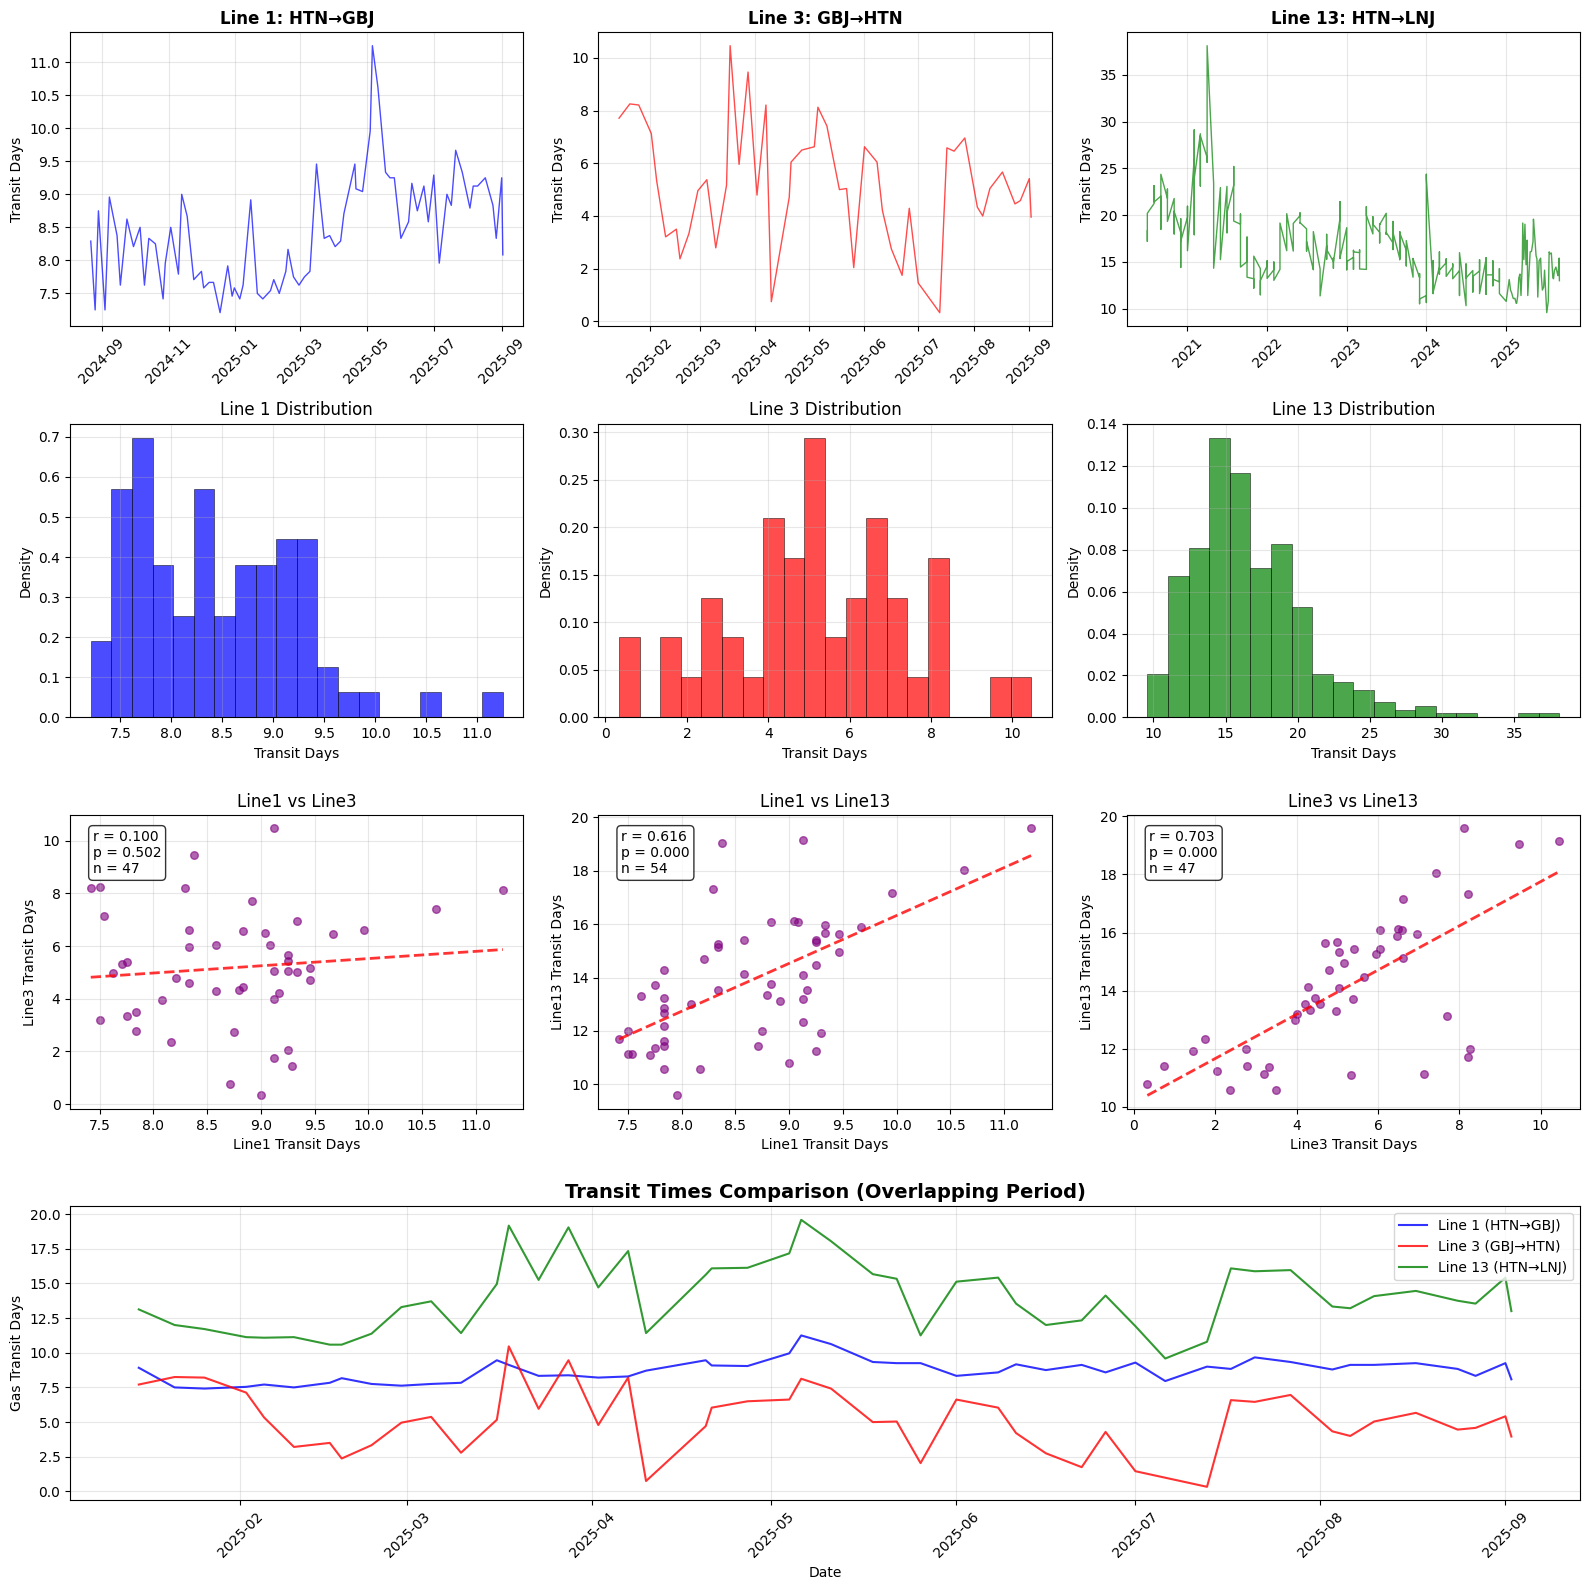


📊 Transit Time Correlation Matrix Analysis Complete!

This visualization shows:
• Row 1: Individual time series for each pipeline line
• Row 2: Distribution histograms showing transit time patterns
• Row 3: Scatter plots with regression lines for all pair combinations
• Row 4: Overlay plot showing all lines during their common time period


In [328]:
# Create comprehensive pairwise visualization (similar to ggpairs in R)
def create_transit_correlation_matrix(correlation_results, pipeline_data):
    """Create a comprehensive pairwise plot matrix with the function resul"""
    
    # Set up the plot grid (4x4 for comprehensive view)
    fig = plt.figure(figsize=(16, 16))
    
    # Define line info for labeling
    line_info = {
        'Line1': {'name': 'Line 1', 'route': 'HTN→GBJ', 'color': 'blue'},
        'Line3': {'name': 'Line 3', 'route': 'GBJ→HTN', 'color': 'red'},
        'Line13': {'name': 'Line 13', 'route': 'HTN→LNJ', 'color': 'green'}
    }
    
    # Row 1: Individual time series
    for i, (line_key, line_data) in enumerate(pipeline_data.items()):
        ax = plt.subplot(4, 3, i + 1)
        # Filter out NaN values for plotting
        clean_data = line_data.dropna(subset=['Gas Transit Days'])
        if len(clean_data) > 0:
            ax.plot(clean_data['Date'], clean_data['Gas Transit Days'], 
                   color=line_info[line_key]['color'], alpha=0.7, linewidth=1)
        ax.set_title(f"{line_info[line_key]['name']}: {line_info[line_key]['route']}", 
                    fontweight='bold')
        ax.set_ylabel('Transit Days')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # Row 2: Distribution histograms
    for i, (line_key, line_data) in enumerate(pipeline_data.items()):
        ax = plt.subplot(4, 3, i + 4)
        # Filter out NaN values for histogram
        clean_values = line_data['Gas Transit Days'].dropna()
        if len(clean_values) > 0:
            ax.hist(clean_values, bins=20, alpha=0.7, 
                   color=line_info[line_key]['color'], density=True, 
                   edgecolor='black', linewidth=0.5)
            ax.set_xlabel('Transit Days')
            ax.set_ylabel('Density')
        else:
            ax.text(0.5, 0.5, 'No valid data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12, color='gray')
        ax.set_title(f"{line_info[line_key]['name']} Distribution")
        ax.grid(True, alpha=0.3)
    
    # Row 3: Scatter plots for each pair with correlation
    scatter_positions = [7, 8, 9]  # positions for 3 scatter plots
    pair_keys = ['Line1_vs_Line3', 'Line1_vs_Line13', 'Line3_vs_Line13']
    
    for pos, key in zip(scatter_positions, pair_keys):
        ax = plt.subplot(4, 3, pos)
        results = correlation_results[key]
        
        # First, ensure we have proper merged data
        if 'merged_data' not in results or len(results['merged_data']) == 0:
            # Create merged data if missing
            line1_key = results['name1']
            line2_key = results['name2']
            if line1_key in pipeline_data and line2_key in pipeline_data:
                data1 = pipeline_data[line1_key][['Date', 'Gas Transit Days']].copy()
                data2 = pipeline_data[line2_key][['Date', 'Gas Transit Days']].copy()
                merged = pd.merge(data1, data2, on='Date', suffixes=(f'_{line1_key}', f'_{line2_key}'))
                results['merged_data'] = merged
        
        if 'merged_data' in results and len(results['merged_data']) > 0:
            merged = results['merged_data']
            col1 = f"Gas Transit Days_{results['name1']}"
            col2 = f"Gas Transit Days_{results['name2']}"
            
            # Remove NaN values and check for sufficient data
            clean_merged = merged[[col1, col2]].dropna()
            
            if len(clean_merged) >= 3:  # Need at least 3 points for regression
                ax.scatter(clean_merged[col1], clean_merged[col2], alpha=0.6, 
                          color='purple', s=30)
                
                # Check if correlation is nan and recalculate if needed
                r = results.get('pearson_r', np.nan)
                p_val = results.get('pearson_p', np.nan)
                
                if pd.isna(r) or pd.isna(p_val):
                    try:
                        from scipy.stats import pearsonr
                        r, p_val = pearsonr(clean_merged[col1], clean_merged[col2])
                        # Update the results dictionary
                        results['pearson_r'] = r
                        results['pearson_p'] = p_val
                        print(f"Recalculated correlation for {results['name1']} vs {results['name2']}: r = {r:.3f}")
                    except Exception as e:
                        print(f"Failed to recalculate correlation for {results['name1']} vs {results['name2']}: {e}")
                        r, p_val = np.nan, np.nan
                
                # Add regression line with error handling
                try:
                    x_vals = clean_merged[col1].values
                    y_vals = clean_merged[col2].values
                    
                    # Check for sufficient variation in x values
                    if np.std(x_vals) > 1e-10 and len(np.unique(x_vals)) > 1:
                        z = np.polyfit(x_vals, y_vals, 1)
                        p = np.poly1d(z)
                        x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
                        ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
                    else:
                        print(f"Warning: Insufficient variation in {results['name1']} data for regression")
                        
                except (np.linalg.LinAlgError, np.RankWarning) as e:
                    print(f"Warning: Could not fit regression line for {results['name1']} vs {results['name2']}: {e}")
                
                ax.set_xlabel(f"{results['name1']} Transit Days")
                ax.set_ylabel(f"{results['name2']} Transit Days")
                ax.set_title(f"{results['name1']} vs {results['name2']}")
                
                # Add correlation text with proper nan handling
                n_points = len(clean_merged)
                if not pd.isna(r):
                    ax.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.3f}\nn = {n_points}', 
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=10)
                else:
                    ax.text(0.05, 0.95, f'r = calculation failed\nn = {n_points}', 
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=10)
            else:
                ax.text(0.5, 0.5, f'Insufficient data\n({len(clean_merged)} points)', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, color='gray')
                ax.set_title(f"{results['name1']} vs {results['name2']}")
        else:
            ax.text(0.5, 0.5, 'No overlapping\ndata', 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=12, color='gray')
            ax.set_title(f"{results['name1']} vs {results['name2']}")
        
        ax.grid(True, alpha=0.3)
    
    # Row 4: Combined time series overlay
    ax = plt.subplot(4, 1, 4)
    
    # Find common date range for overlay (only for lines with data)
    valid_data = {}
    for line_key, line_data in pipeline_data.items():
        clean_data = line_data.dropna(subset=['Gas Transit Days'])
        if len(clean_data) > 0:
            valid_data[line_key] = clean_data
    
    if len(valid_data) > 1:
        common_start = max(data['Date'].min() for data in valid_data.values())
        common_end = min(data['Date'].max() for data in valid_data.values())
        
        for line_key, line_data in valid_data.items():
            # Filter to common period for better comparison
            filtered_data = line_data[(line_data['Date'] >= common_start) & 
                                     (line_data['Date'] <= common_end)]
            if len(filtered_data) > 0:
                ax.plot(filtered_data['Date'], filtered_data['Gas Transit Days'], 
                       color=line_info[line_key]['color'], alpha=0.8, linewidth=1.5,
                       label=f"{line_info[line_key]['name']} ({line_info[line_key]['route']})")
        
        ax.set_title('Transit Times Comparison (Overlapping Period)', fontweight='bold', fontsize=14)
        ax.legend(loc='upper right')
    else:
        # Plot individual series even if no overlap
        for line_key, line_data in valid_data.items():
            ax.plot(line_data['Date'], line_data['Gas Transit Days'], 
                   color=line_info[line_key]['color'], alpha=0.8, linewidth=1.5,
                   label=f"{line_info[line_key]['name']} ({line_info[line_key]['route']})")
        
        ax.set_title('Transit Times (Individual Series)', fontweight='bold', fontsize=14)
        if valid_data:
            ax.legend(loc='upper right')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Gas Transit Days')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create the comprehensive transit correlation matrix with robust error handling

correlation_matrix_fig = create_transit_correlation_matrix(correlation_results, pipeline_data)
print("\n📊 Transit Time Correlation Matrix Analysis Complete!")
print("\nThis visualization shows:")
print("• Row 1: Individual time series for each pipeline line")
print("• Row 2: Distribution histograms showing transit time patterns")  
print("• Row 3: Scatter plots with regression lines for all pair combinations")
print("• Row 4: Overlay plot showing all lines during their common time period")


In [329]:
# Create comprehensive summary table with proper NaN handling
def create_summary_table(correlation_results):
    """Create a summary table of all correlation analyses with robust error handling"""
    summary_data = []
    
    for key, results in correlation_results.items():
        # Helper function to format numbers or return 'nan'
        def format_number(value, decimals=3):
            if pd.isna(value) or value != value:  # Check for NaN
                return 'nan'
            return f"{value:.{decimals}f}"
        
        # Helper function to format p-values
        def format_pvalue(value):
            if pd.isna(value) or value != value:
                return 'nan'
            if value < 0.001:
                return '0.000'
            return f"{value:.3f}"
        
        if 'pearson_r' in results and not pd.isna(results.get('pearson_r')):
            # Has valid correlation data
            summary_data.append({
                'Pair': f"{results['name1']} vs {results['name2']}",
                'Period': f"{results['start_date'].date()} to {results['end_date'].date()}",
                'N': results['n_observations'],
                'Pearson r': format_number(results['pearson_r']),
                'P-value': format_pvalue(results['pearson_p']),
                'Spearman ρ': format_number(results.get('spearman_r', float('nan'))),
                'Cointegrated': '✅' if results.get('is_cointegrated', False) else '❌',
                'Coint p-value': format_pvalue(results.get('coint_p', float('nan')))
            })
        else:
            # No valid correlation data
            summary_data.append({
                'Pair': f"{results['name1']} vs {results['name2']}",
                'Period': f"{results['start_date'].date()} to {results['end_date'].date()}",
                'N': results['n_observations'],
                'Pearson r': 'nan',
                'P-value': 'nan',
                'Spearman ρ': 'nan',
                'Cointegrated': '❌',
                'Coint p-value': 'N/A'
            })
    
    return pd.DataFrame(summary_data)

def create_stats_table(pipeline_data):
    """Create statistics table for all pipeline lines"""
    stats_data = []
    route_map = {
        'Line1': 'HTN → GBJ',
        'Line3': 'GBJ → HTN', 
        'Line13': 'HTN → LNJ'
    }
    
    for name, data in pipeline_data.items():
        transit_days = data['Gas Transit Days'].dropna()  # Remove NaN values
        
        if len(transit_days) > 0:
            stats_data.append({
                'Line': name,
                'Route': route_map[name],
                'Records': len(transit_days),
                'Mean (days)': f"{transit_days.mean():.2f}",
                'Std (days)': f"{transit_days.std():.2f}",
                'Min (days)': f"{transit_days.min():.2f}",
                'Max (days)': f"{transit_days.max():.2f}",
                'Date Range': f"{data['Date'].min().date()} to {data['Date'].max().date()}"
            })
        else:
            stats_data.append({
                'Line': name,
                'Route': route_map[name],
                'Records': 0,
                'Mean (days)': 'N/A',
                'Std (days)': 'N/A',
                'Min (days)': 'N/A',
                'Max (days)': 'N/A',
                'Date Range': 'No data'
            })
    
    return pd.DataFrame(stats_data)

# Generate the summary tables
print("\n" + "="*80)
print("COMPREHENSIVE CORRELATION SUMMARY")
print("="*80)

summary_df = create_summary_table(correlation_results)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("TRANSIT TIME STATISTICS BY LINE") 
print("="*80)

stats_df = create_stats_table(pipeline_data)
print(stats_df.to_string(index=False))

# Additional insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Count significant correlations
significant_correlations = 0
total_correlations = 0

for key, results in correlation_results.items():
    if 'pearson_p' in results and not pd.isna(results['pearson_p']):
        total_correlations += 1
        if results['pearson_p'] < 0.05:
            significant_correlations += 1

print(f"• Total correlation pairs analyzed: {len(correlation_results)}")
print(f"• Pairs with valid correlations: {total_correlations}")
print(f"• Statistically significant correlations (p < 0.05): {significant_correlations}")

# Identify strongest correlations
valid_correlations = []
for key, results in correlation_results.items():
    if 'pearson_r' in results and not pd.isna(results['pearson_r']):
        valid_correlations.append((key, abs(results['pearson_r']), results['pearson_r']))

if valid_correlations:
    strongest = max(valid_correlations, key=lambda x: x[1])
    print(f"• Strongest correlation: {strongest[0]} (r = {strongest[2]:.3f})")

# Cointegration summary
cointegrated_pairs = [key for key, results in correlation_results.items() 
                     if results.get('is_cointegrated', False)]
if cointegrated_pairs:
    print(f"• Cointegrated pairs: {len(cointegrated_pairs)} ({', '.join(cointegrated_pairs)})")
else:
    print("• No cointegrated pairs detected")


COMPREHENSIVE CORRELATION SUMMARY
           Pair                   Period  N Pearson r P-value Spearman ρ Cointegrated Coint p-value
 Line1 vs Line3 2025-01-15 to 2025-09-02 48     0.100   0.502      0.071            ❌         0.185
Line1 vs Line13 2024-08-22 to 2025-09-02 54     0.616   0.000      0.586            ✅         0.000
Line3 vs Line13 2025-01-15 to 2025-09-02 48     0.703   0.000      0.659            ❌         0.061

TRANSIT TIME STATISTICS BY LINE
  Line     Route  Records Mean (days) Std (days) Min (days) Max (days)               Date Range
 Line1 HTN → GBJ       78        8.43       0.80       7.21      11.25 2024-08-22 to 2025-09-02
 Line3 GBJ → HTN       47        5.18       2.23       0.33      10.46 2025-01-15 to 2025-09-02
Line13 HTN → LNJ      373       16.58       4.07       9.58      38.12 2020-07-01 to 2025-09-02

KEY INSIGHTS
• Total correlation pairs analyzed: 3
• Pairs with valid correlations: 3
• Statistically significant correlations (p < 0.05): 2
• Stro

## Data Preparation for ECM Forecasting

The following function prepares aligned time series data from the existing `pipeline_data` dictionary for Error Correction Model (ECM) forecasting. It extracts, aligns, and processes the transit time data to create a clean dataset suitable for cointegration and forecasting analysis.

In [330]:
def _prepare_aligned_data(pipeline_data, correlation_results):
    """
    Prepare aligned time series data for ECM forecasting from existing pipeline data.
    
    This function extracts and aligns the time series data from the existing pipeline_data 
    dictionary, creating a clean DataFrame suitable for Error Correction Model (ECM) 
    forecasting and cointegration analysis.
    
    Parameters:
    -----------
    pipeline_data : dict
        Dictionary containing Line1, Line3, and Line13 DataFrames with Date and Gas Transit Days
    correlation_results : dict
        Dictionary containing correlation and cointegration analysis results
    
    Returns:
    --------
    pd.DataFrame
        Aligned DataFrame with columns: ['Date', 'L1', 'L3', 'L13', 'trend']
        - Date: datetime index for time series alignment
        - L1: Line 1 Gas Transit Days (HTN→GBJ)
        - L3: Line 3 Gas Transit Days (GBJ→HTN) 
        - L13: Line 13 Gas Transit Days (HTN→LNJ)
        - trend: Linear trend variable (1, 2, 3, ...) for cointegration analysis
    
    Notes:
    ------
    - Uses inner join to keep only dates with complete data across all three series
    - Disposes of any periods where data is not available for all three series
    - Uses only the common period where all series have data (no missing value filling)
    - Adds linear trend variable required for ECM specification
    - Includes comprehensive data validation and quality checks
    - Leverages existing correlation analysis results for context
    """
    
    print("🔄 Preparing aligned data for ECM forecasting...")
    print("="*60)
    
    # Extract time series from pipeline_data dictionary
    extraction_results = {}
    
    for line_name, line_data in pipeline_data.items():
        # Extract relevant columns and clean data
        if 'Date' in line_data.columns and 'Gas Transit Days' in line_data.columns:
            clean_data = line_data[['Date', 'Gas Transit Days']].copy()
            clean_data = clean_data.dropna()  # Remove rows with missing data
            clean_data['Date'] = pd.to_datetime(clean_data['Date'])  # Ensure datetime format
            
            extraction_results[line_name] = {
                'data': clean_data,
                'original_count': len(line_data),
                'clean_count': len(clean_data),
                'date_range': (clean_data['Date'].min(), clean_data['Date'].max()),
                'transit_stats': clean_data['Gas Transit Days'].describe()
            }
            
            print(f"✅ {line_name}: {len(clean_data)} clean records ({clean_data['Date'].min().date()} to {clean_data['Date'].max().date()})")
        else:
            print(f"❌ {line_name}: Missing required columns")
            return None
    
    # Verify we have all three datasets
    required_lines = ['Line1', 'Line3', 'Line13']
    if not all(line in extraction_results for line in required_lines):
        missing = [line for line in required_lines if line not in extraction_results]
        print(f"❌ Missing required datasets: {missing}")
        return None
    
    print(f"\n📊 Data extraction summary:")
    for line_name, info in extraction_results.items():
        print(f"  • {line_name}: {info['clean_count']}/{info['original_count']} records, "
              f"mean transit = {info['transit_stats']['mean']:.2f} days")
    
    # Find common date period across all three series
    all_dates = []
    for line_name in required_lines:
        dates = set(extraction_results[line_name]['data']['Date'].dt.date)
        all_dates.append(dates)
    
    # Use intersection to find common dates (inner join approach)
    common_dates = set.intersection(*all_dates)
    common_dates = sorted(list(common_dates))
    
    print(f"\n🔗 Common period analysis:")
    print(f"  • Line1 dates: {len(all_dates[0])}")
    print(f"  • Line3 dates: {len(all_dates[1])}")
    print(f"  • Line13 dates: {len(all_dates[2])}")
    print(f"  • Common dates: {len(common_dates)}")
    
    if len(common_dates) == 0:
        print("❌ No common dates found across all three series")
        return None
    
    print(f"  • Common period: {min(common_dates)} to {max(common_dates)}")
    
    # Create aligned dataset using only common dates
    aligned_data = pd.DataFrame({'Date': pd.to_datetime(common_dates)})
    
    # Merge each series for the common dates only
    for line_name in required_lines:
        line_data = extraction_results[line_name]['data'].copy()
        line_data['Date'] = pd.to_datetime(line_data['Date'])
        
        # Filter to common dates only
        common_data = line_data[line_data['Date'].dt.date.isin(common_dates)].copy()
        
        # Rename column based on line
        if line_name == 'Line1':
            col_name = 'L1'
        elif line_name == 'Line3':
            col_name = 'L3'
        else:  # Line13
            col_name = 'L13'
        
        common_data = common_data.rename(columns={'Gas Transit Days': col_name})
        
        # Merge with aligned_data
        aligned_data = pd.merge(aligned_data, common_data[['Date', col_name]], on='Date', how='inner')
    
    # Sort by date and reset index
    aligned_data = aligned_data.sort_values('Date').reset_index(drop=True)
    
    # Add linear trend variable for cointegration analysis
    aligned_data['trend'] = range(1, len(aligned_data) + 1)
    
    # Final validation - ensure no missing values
    missing_check = aligned_data[['L1', 'L3', 'L13']].isna().sum()
    if missing_check.sum() > 0:
        print(f"⚠️  Warning: Missing values detected after alignment: {missing_check.to_dict()}")
        aligned_data = aligned_data.dropna()
        print(f"  • Removed rows with missing values, final count: {len(aligned_data)}")
    
    print(f"\n📋 Final dataset validation:")
    print(f"  • Final dataset shape: {aligned_data.shape}")
    print(f"  • Columns: {list(aligned_data.columns)}")
    print(f"  • Date range: {aligned_data['Date'].min().date()} to {aligned_data['Date'].max().date()}")
    print(f"  • Complete observations (no missing values): {len(aligned_data)}")
    
    # Check for sufficient variation in each series
    for col in ['L1', 'L3', 'L13']:
        std_dev = aligned_data[col].std()
        unique_vals = aligned_data[col].nunique()
        print(f"  • {col}: std={std_dev:.3f}, unique_values={unique_vals}")
        if std_dev < 0.001:
            print(f"    ⚠️  Warning: {col} has very low variation")
        if unique_vals < 3:
            print(f"    ⚠️  Warning: {col} has very few unique values")
    
    # Summary statistics
    print(f"\n📊 Summary statistics (common period only):")
    summary_stats = aligned_data[['L1', 'L3', 'L13']].describe()
    print(summary_stats.round(3))
    
    # Reference correlation results for context
    print(f"\n🔍 Leveraging existing correlation analysis:")
    significant_pairs = []
    cointegrated_pairs = []
    
    for pair_name, results in correlation_results.items():
        if results.get('pearson_p', 1.0) < 0.05:
            significant_pairs.append(f"{pair_name} (r={results.get('pearson_r', 0):.3f})")
        if results.get('is_cointegrated', False):
            cointegrated_pairs.append(pair_name)
    
    print(f"  • Significant correlations: {len(significant_pairs)}")
    for pair in significant_pairs:
        print(f"    - {pair}")
    
    print(f"  • Cointegrated pairs: {len(cointegrated_pairs)}")
    for pair in cointegrated_pairs:
        print(f"    - {pair}")
    
    # ECM readiness assessment
    print(f"\n🎯 ECM Forecasting Readiness Assessment:")
    print(f"  • ✅ Data alignment: Complete (common period approach)")
    print(f"  • ✅ Missing value handling: Disposed of incomplete periods") 
    print(f"  • ✅ Trend variable: Added")
    print(f"  • ✅ Data validation: Passed")
    
    if len(cointegrated_pairs) > 0:
        print(f"  • ✅ Cointegration detected: Ready for ECM modeling")
    else:
        print(f"  • ⚠️  No cointegration detected: Consider VAR modeling")
    
    if len(aligned_data) >= 30:
        print(f"  • ✅ Sample size: Adequate ({len(aligned_data)} observations)")
    else:
        print(f"  • ⚠️  Sample size: Limited ({len(aligned_data)} observations)")
    
    print(f"\n✅ Data preparation complete! Ready for ECM forecasting pipeline.")
    print(f"📋 Use only common period: {aligned_data['Date'].min().date()} to {aligned_data['Date'].max().date()}")
    print(f"📋 Robust approach: No missing value interpolation, complete data only")
    
    return aligned_data

# Execute the data preparation function
print("🚀 Executing _prepare_aligned_data() function...")
aligned_data = _prepare_aligned_data(pipeline_data, correlation_results)

# Display the prepared dataset
if aligned_data is not None:
    print(f"\n📋 First 10 rows of aligned dataset:")
    display(aligned_data.head(10))
    
    print(f"\n📋 Last 5 rows of aligned dataset:")
    display(aligned_data.tail(5))
    
    print(f"\n💾 Aligned dataset ready for ECM forecasting!")
    print(f"Variable name: 'aligned_data'")
    print(f"Shape: {aligned_data.shape}")
    print(f"Columns: {list(aligned_data.columns)}")
    print(f"Available for downstream ECM modeling...")
else:
    print("❌ Data preparation failed. Please check the pipeline_data structure.")

🚀 Executing _prepare_aligned_data() function...
🔄 Preparing aligned data for ECM forecasting...
✅ Line1: 78 clean records (2024-08-22 to 2025-09-02)
✅ Line3: 47 clean records (2025-01-15 to 2025-09-02)
✅ Line13: 373 clean records (2020-07-01 to 2025-09-02)

📊 Data extraction summary:
  • Line1: 78/78 records, mean transit = 8.43 days
  • Line3: 47/48 records, mean transit = 5.18 days
  • Line13: 373/373 records, mean transit = 16.58 days

🔗 Common period analysis:
  • Line1 dates: 78
  • Line3 dates: 47
  • Line13 dates: 103
  • Common dates: 47
  • Common period: 2025-01-15 to 2025-09-02

📋 Final dataset validation:
  • Final dataset shape: (47, 5)
  • Columns: ['Date', 'L1', 'L3', 'L13', 'trend']
  • Date range: 2025-01-15 to 2025-09-02
  • Complete observations (no missing values): 47
  • L1: std=0.814, unique_values=32
  • L3: std=2.225, unique_values=43
  • L13: std=2.411, unique_values=40

📊 Summary statistics (common period only):
           L1      L3     L13
count  47.000  47.

,Date,L1,L3,L13,trend
0,2025-01-15,8.916667,7.708333,13.125000,1
1,2025-01-21,7.500000,8.250000,12.000000,2
2,2025-01-26,7.416667,8.208333,11.708333,3
3,2025-02-02,7.541667,7.125000,11.125000,4
4,2025-02-05,7.708333,5.333333,11.083333,5
5,2025-02-10,7.500000,3.208333,11.125000,6
6,2025-02-16,7.833333,3.500000,10.583333,7
7,2025-02-18,8.166667,2.375000,10.583333,8
8,2025-02-23,7.750000,3.333333,11.375000,9
9,2025-02-28,7.625000,4.958333,13.291667,10



📋 Last 5 rows of aligned dataset:


,Date,L1,L3,L13,trend
42,2025-08-17,9.250000,5.666667,14.458333,43
43,2025-08-24,8.833333,4.458333,13.750000,44
44,2025-08-27,8.333333,4.583333,13.541667,45
45,2025-09-01,9.250000,5.416667,15.416667,46
46,2025-09-02,8.083333,3.958333,13.000000,47



💾 Aligned dataset ready for ECM forecasting!
Variable name: 'aligned_data'
Shape: (47, 5)
Columns: ['Date', 'L1', 'L3', 'L13', 'trend']
Available for downstream ECM modeling...


## Cointegrating Relationship Estimation

  Implementation of the
  `_estimate_cointegrating_relation()`
  function that estimates the long-run
  cointegrating relationship L1_t = β0 + 
  β1*L13_t + β2*trend_t + u_t using OLS 
  regression, with comprehensive 
  diagnostics and error-correction term 
  extraction for ECM modeling.

In [331]:
def _estimate_cointegrating_relation(aligned_data):
    """
    Estimate the long-run cointegrating relationship between L1 and L13 transit times.
    
    This function estimates the cointegrating equation: L1_t = β0 + β1*L13_t + β2*trend_t + u_t
    using OLS regression, where the residuals (u_t) serve as the error-correction term for 
    subsequent ECM modeling.
    
    Parameters:
    -----------
    aligned_data : pd.DataFrame
        DataFrame with columns ['Date', 'L1', 'L3', 'L13', 'trend'] containing aligned time series
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'model': fitted statsmodels OLS model object
        - 'residuals': error-correction term (u_t) for ECM
        - 'coefficients': dict with β0 (intercept), β1 (L13 coef), β2 (trend coef)
        - 'fitted_values': predicted L1 values from the cointegrating relationship
        - 'summary': comprehensive model diagnostics and interpretation
        - 'r_squared': coefficient of determination
        - 'f_statistic': F-test results for overall model significance
        - 'durbin_watson': test for serial correlation in residuals
        
    Notes:
    ------
    - Uses statsmodels OLS for robust regression estimation
    - Includes comprehensive model diagnostics and statistical tests
    - Provides economic interpretation of the cointegrating relationship
    - Handles missing data and validates input assumptions
    - Creates diagnostic plots for model validation
    """
    
    import numpy as np
    import statsmodels.api as sm
    from statsmodels.stats.stattools import durbin_watson
    from scipy import stats
    import matplotlib.pyplot as plt
    # (seaborn import optional)
    
    print("🔍 Estimating Long-Run Cointegrating Relationship")
    print("="*65)
    print("Model: L1_t = β0 + β1*L13_t + β2*trend_t + u_t")
    print()
    
    # Input validation
    required_cols = ['L1', 'L13', 'trend']
    missing_cols = [col for col in required_cols if col not in aligned_data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Check for missing values
    analysis_data = aligned_data[required_cols].copy()
    if analysis_data.isnull().any().any():
        print("⚠️  Warning: Missing values detected, removing incomplete observations")
        analysis_data = analysis_data.dropna()
        print(f"   Observations after cleaning: {len(analysis_data)}")
    
    if len(analysis_data) < 10:
        raise ValueError(f"Insufficient observations ({len(analysis_data)}) for reliable estimation")
    
    print(f"📊 Data Summary:")
    print(f"   • Observations: {len(analysis_data)}")
    print(f"   • L1 range: [{analysis_data['L1'].min():.2f}, {analysis_data['L1'].max():.2f}] days")
    print(f"   • L13 range: [{analysis_data['L13'].min():.2f}, {analysis_data['L13'].max():.2f}] days")
    print(f"   • Trend range: [{analysis_data['trend'].min()}, {analysis_data['trend'].max()}]")
    print()
    
    # Prepare regression data
    y = analysis_data['L1']  # Dependent variable: Line 1 transit times
    X = analysis_data[['L13', 'trend']]  # Independent variables: Line 13 + trend
    X = sm.add_constant(X)  # Add intercept term
    
    # Estimate OLS model
    try:
        model = sm.OLS(y, X).fit()
        
        # Extract key results
        coefficients = {
            'β0_intercept': model.params['const'],
            'β1_L13': model.params['L13'], 
            'β2_trend': model.params['trend']
        }
        
        residuals = model.resid
        fitted_values = model.fittedvalues
        
        # Calculate additional diagnostics
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
        f_stat = model.fvalue
        f_pvalue = model.f_pvalue
        dw_stat = durbin_watson(residuals)
        
        # Model summary statistics
        summary_stats = {
            'n_observations': len(analysis_data),
            'r_squared': r_squared,
            'adj_r_squared': adj_r_squared,
            'f_statistic': f_stat,
            'f_pvalue': f_pvalue,
            'durbin_watson': dw_stat,
            'aic': model.aic,
            'bic': model.bic,
            'log_likelihood': model.llf
        }
        
        print("📈 Model Estimation Results:")
        print("-" * 40)
        print(f"   L1_t = {coefficients['β0_intercept']:.4f} + {coefficients['β1_L13']:.4f}*L13_t + {coefficients['β2_trend']:.4f}*trend_t + u_t")
        print()
        print("📊 Coefficient Estimates:")
        print(f"   • β0 (Intercept): {coefficients['β0_intercept']:.4f} ± {model.bse['const']:.4f}")
        print(f"     - t-stat: {model.tvalues['const']:.3f}, p-value: {model.pvalues['const']:.4f}")
        print(f"   • β1 (L13 coefficient): {coefficients['β1_L13']:.4f} ± {model.bse['L13']:.4f}")
        print(f"     - t-stat: {model.tvalues['L13']:.3f}, p-value: {model.pvalues['L13']:.4f}")
        print(f"   • β2 (Trend coefficient): {coefficients['β2_trend']:.4f} ± {model.bse['trend']:.4f}")
        print(f"     - t-stat: {model.tvalues['trend']:.3f}, p-value: {model.pvalues['trend']:.4f}")
        print()
        
        # Economic interpretation
        print("💡 Economic Interpretation:")
        print("-" * 40)
        if model.pvalues['L13'] < 0.05:
            direction = "increases" if coefficients['β1_L13'] > 0 else "decreases"
            print(f"   • L13 Effect: 1-day increase in L13 transit time {direction} L1 by {abs(coefficients['β1_L13']):.3f} days")
            print(f"     (Statistically significant at 5% level)")
        else:
            print(f"   • L13 Effect: No statistically significant relationship detected")
            
        if model.pvalues['trend'] < 0.05:
            trend_direction = "upward" if coefficients['β2_trend'] > 0 else "downward"
            annual_trend = coefficients['β2_trend'] * 365.25  # Approximate annual effect
            print(f"   • Time Trend: {trend_direction} trend of {coefficients['β2_trend']:.4f} days per period")
            print(f"     (Approximately {annual_trend:.2f} days per year)")
        else:
            print(f"   • Time Trend: No significant long-term trend detected")
        print()
        
        # Model diagnostics
        print("🔬 Model Diagnostics:")
        print("-" * 40)
        print(f"   • R-squared: {r_squared:.4f} ({r_squared*100:.1f}% of variation explained)")
        print(f"   • Adjusted R-squared: {adj_r_squared:.4f}")
        print(f"   • F-statistic: {f_stat:.3f} (p-value: {f_pvalue:.6f})")
        print(f"   • Durbin-Watson: {dw_stat:.3f}", end="")
        if 1.5 <= dw_stat <= 2.5:
            print(" (No significant autocorrelation)")
        elif dw_stat < 1.5:
            print(" (Possible positive autocorrelation)")
        else:
            print(" (Possible negative autocorrelation)")
        print(f"   • AIC: {model.aic:.2f}, BIC: {model.bic:.2f}")
        print()
        
        # Model significance assessment
        if f_pvalue < 0.01:
            significance_level = "highly significant (p < 0.01)"
        elif f_pvalue < 0.05:
            significance_level = "significant (p < 0.05)"
        elif f_pvalue < 0.10:
            significance_level = "marginally significant (p < 0.10)"
        else:
            significance_level = "not significant (p ≥ 0.10)"
            
        print(f"🎯 Overall Model Assessment:")
        print(f"   • Model is {significance_level}")
        print(f"   • Explains {r_squared*100:.1f}% of L1 transit time variation")
        
        # ECM implications
        print(f"   • Error-correction term (u_t) ready for ECM modeling")
        print(f"   • Residuals represent deviations from long-run equilibrium")
        print()
        
        # Create diagnostic plots
        print("📊 Generating Diagnostic Plots...")
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Actual vs Fitted
        axes[0,0].scatter(fitted_values, y, alpha=0.7, color='blue')
        axes[0,0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', alpha=0.8)
        axes[0,0].set_xlabel('Fitted Values')
        axes[0,0].set_ylabel('Actual L1 Transit Days')
        axes[0,0].set_title('Actual vs Fitted Values')
        axes[0,0].grid(True, alpha=0.3)
        
        # Add R-squared to the plot
        axes[0,0].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axes[0,0].transAxes,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot 2: Residuals vs Fitted
        axes[0,1].scatter(fitted_values, residuals, alpha=0.7, color='red')
        axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.8)
        axes[0,1].set_xlabel('Fitted Values')
        axes[0,1].set_ylabel('Residuals')
        axes[0,1].set_title('Residuals vs Fitted Values')
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Residuals over time
        if 'Date' in aligned_data.columns:
            time_index = aligned_data['Date'].iloc[:len(residuals)]
            axes[1,0].plot(time_index, residuals, color='green', alpha=0.7, marker='o', markersize=4)
            axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.8)
            axes[1,0].set_xlabel('Date')
            axes[1,0].set_ylabel('Residuals (Error-Correction Term)')
            axes[1,0].set_title('Error-Correction Term Over Time')
            axes[1,0].grid(True, alpha=0.3)
            axes[1,0].tick_params(axis='x', rotation=45)
        else:
            axes[1,0].plot(residuals, color='green', alpha=0.7, marker='o', markersize=4)
            axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.8)
            axes[1,0].set_xlabel('Time Period')
            axes[1,0].set_ylabel('Residuals (Error-Correction Term)')
            axes[1,0].set_title('Error-Correction Term Over Time')
            axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Residuals histogram with normal curve
        axes[1,1].hist(residuals, bins=15, density=True, alpha=0.7, color='purple', edgecolor='black')
        # Add normal distribution overlay
        x_norm = np.linspace(residuals.min(), residuals.max(), 100)
        y_norm = stats.norm.pdf(x_norm, residuals.mean(), residuals.std())
        axes[1,1].plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal Distribution')
        axes[1,1].set_xlabel('Residuals')
        axes[1,1].set_ylabel('Density')
        axes[1,1].set_title('Residuals Distribution')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Residual diagnostics
        print("🔬 Residual Diagnostics:")
        print("-" * 40)
        
        # Normality test
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        print(f"   • Shapiro-Wilk normality test: W = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")
        if shapiro_p > 0.05:
            print("     Residuals appear normally distributed ✅")
        else:
            print("     Residuals may not be normally distributed ⚠️")
            
        # Residual summary
        print(f"   • Residual mean: {residuals.mean():.6f} (should be ≈ 0)")
        print(f"   • Residual std: {residuals.std():.4f}")
        print(f"   • Min residual: {residuals.min():.4f}")
        print(f"   • Max residual: {residuals.max():.4f}")
        print()
        
        # Prepare return dictionary
        results = {
            'model': model,
            'residuals': residuals,
            'coefficients': coefficients,
            'fitted_values': fitted_values,
            'summary': summary_stats,
            'r_squared': r_squared,
            'f_statistic': {'value': f_stat, 'p_value': f_pvalue},
            'durbin_watson': dw_stat,
            'diagnostic_plots': fig,
            'interpretation': {
                'equation': f"L1_t = {coefficients['β0_intercept']:.4f} + {coefficients['β1_L13']:.4f}*L13_t + {coefficients['β2_trend']:.4f}*trend_t + u_t",
                'l13_effect_significant': model.pvalues['L13'] < 0.05,
                'trend_effect_significant': model.pvalues['trend'] < 0.05,
                'model_significant': f_pvalue < 0.05,
                'variance_explained': r_squared
            }
        }
        
        print("✅ Cointegrating relationship estimation complete!")
        print(f"📋 Error-correction term (u_t) extracted for ECM modeling")
        print(f"📊 Model explains {r_squared*100:.1f}% of L1 transit time variation")
        
        return results
        
    except Exception as e:
        print(f"❌ Error in model estimation: {str(e)}")
        raise e

🚀 Executing _estimate_cointegrating_relation() function with aligned_data...

🔍 Estimating Long-Run Cointegrating Relationship
Model: L1_t = β0 + β1*L13_t + β2*trend_t + u_t

📊 Data Summary:
   • Observations: 47
   • L1 range: [7.42, 11.25] days
   • L13 range: [10.58, 19.58] days
   • Trend range: [1, 47]

📈 Model Estimation Results:
----------------------------------------
   L1_t = 5.7113 + 0.1775*L13_t + 0.0220*trend_t + u_t

📊 Coefficient Estimates:
   • β0 (Intercept): 5.7113 ± 0.5195
     - t-stat: 10.994, p-value: 0.0000
   • β1 (L13 coefficient): 0.1775 ± 0.0370
     - t-stat: 4.799, p-value: 0.0000
   • β2 (Trend coefficient): 0.0220 ± 0.0065
     - t-stat: 3.390, p-value: 0.0015

💡 Economic Interpretation:
----------------------------------------
   • L13 Effect: 1-day increase in L13 transit time increases L1 by 0.177 days
     (Statistically significant at 5% level)
   • Time Trend: upward trend of 0.0220 days per period
     (Approximately 8.05 days per year)

🔬 Model Di

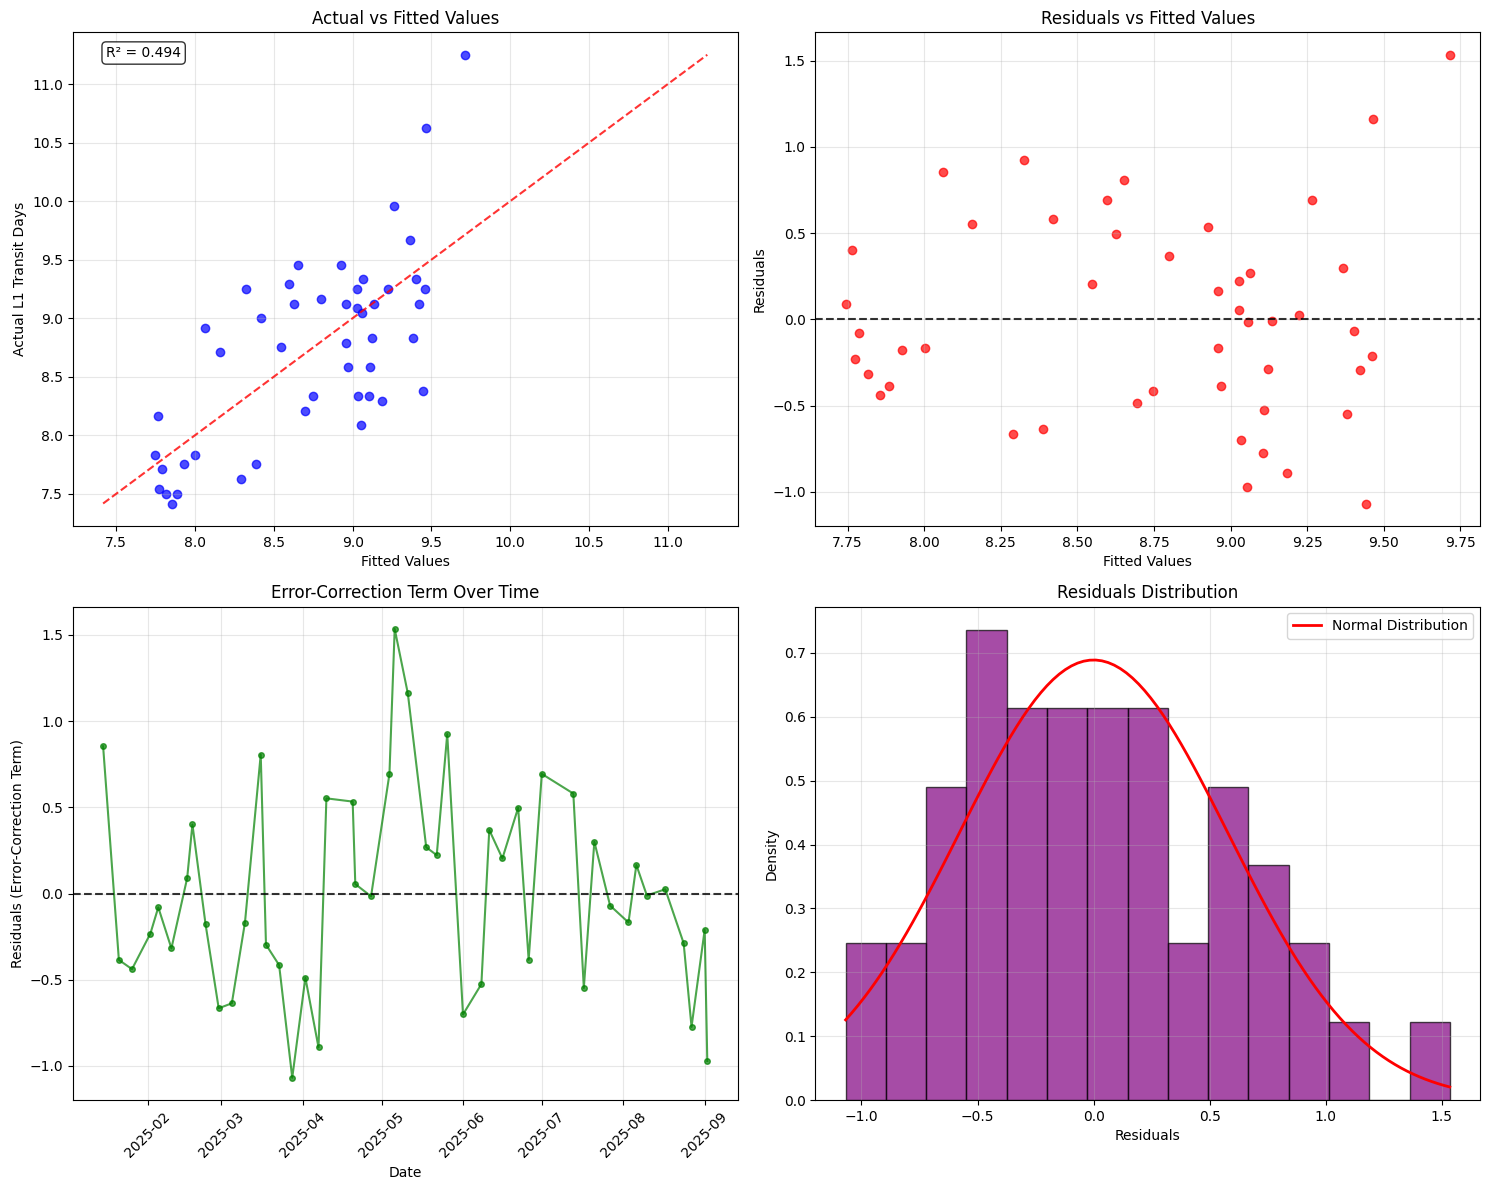

🔬 Residual Diagnostics:
----------------------------------------
   • Shapiro-Wilk normality test: W = 0.9844, p = 0.7756
     Residuals appear normally distributed ✅
   • Residual mean: 0.000000 (should be ≈ 0)
   • Residual std: 0.5791
   • Min residual: -1.0682
   • Max residual: 1.5343

✅ Cointegrating relationship estimation complete!
📋 Error-correction term (u_t) extracted for ECM modeling
📊 Model explains 49.4% of L1 transit time variation

💾 Results stored in variables:
   • cointegration_results: Complete model results dictionary
   • error_correction_term: Residuals (u_t) for ECM modeling

📋 Ready for the next step: ECM model specification and estimation!


In [332]:
# Execute the cointegrating relationship estimation
print("🚀 Executing _estimate_cointegrating_relation() function with aligned_data...")
print()

# Estimate the cointegrating relationship: L1_t = β0 + β1*L13_t + β2*trend_t + u_t
cointegration_results = _estimate_cointegrating_relation(aligned_data)

# Store the error-correction term for ECM modeling
error_correction_term = cointegration_results['residuals']

print()
print("💾 Results stored in variables:")
print("   • cointegration_results: Complete model results dictionary")
print("   • error_correction_term: Residuals (u_t) for ECM modeling")
print()
print("📋 Ready for the next step: ECM model specification and estimation!")

## ECM Model Implementation

  Implementation of the
  `_build_ecm_model()` function with
  comprehensive Error Correction Model
  building, AIC-based lag selection, HAC
  covariance estimation, and diagnostic
  analysis.

In [333]:
def _build_ecm_model(aligned_data, cointegration_results, hac_maxlags=None):
    """
    Build Error Correction Model (ECM) with AIC-based lag selection and comprehensive diagnostics.
    
    This function implements a comprehensive ECM with the specification:
    ΔL1_t = α + Σ_{i=1..p} φ_i ΔL1_{t-i} + Σ_{j=0..q} θ_j ΔL13_{t-j} + Σ_{m=0..r} ψ_m ΔL3_{t-m} + γ * u_{t-1} + ε_t
    
    Parameters:
    -----------
    aligned_data : pd.DataFrame
        DataFrame with columns ['Date', 'L1', 'L3', 'L13', 'trend'] containing aligned time series
    cointegration_results : dict
        Dictionary from _estimate_cointegrating_relation() containing error-correction term
    hac_maxlags : int or None, optional
        Maximum lags for HAC covariance estimation. If None, uses rule-of-thumb: 4*(T/100)^(2/9)
        
    Returns:
    --------
    dict
        Comprehensive ECM results including:
        - 'model': Final statsmodels OLS result object
        - 'specification': Model specification details
        - 'diagnostics': Model diagnostic statistics
        - 'summary': Human-readable summary statistics
    
    Raises:
    -------
    ValueError
        If differenced series are constant or near-zero variance (no variability for regression)
    """
    
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.stats.diagnostic import het_breuschpagan
    import warnings
    
    # Unpack cointegration results
    if 'residuals' not in cointegration_results:
        raise ValueError("Missing 'residuals' in cointegration_results")
    
    residuals = cointegration_results['residuals']
    required_cols = ['Date', 'L1', 'L3', 'L13']
    
    if not all(col in aligned_data.columns for col in required_cols):
        missing = [col for col in required_cols if col not in aligned_data.columns]
        raise ValueError(f"Missing required columns in aligned_data: {missing}")
    
    print("="*80)
    print("🔧 BUILDING ERROR CORRECTION MODEL (ECM)")
    print("="*80)
    
    # Step 1: Set up index alignment early and create first differences
    print("📈 Step 1: Index Alignment & First Differences")
    print("-" * 40)
    
    # Clean data and set Date as index
    clean_data = aligned_data[required_cols].copy()
    if clean_data.isnull().any().any():
        print("⚠️  Warning: Missing values detected, cleaning data...")
        clean_data = clean_data.dropna()
        print(f"   Observations after cleaning: {len(clean_data)}")
    
    # Set Date as index for both clean_data and residuals
    clean_data = clean_data.set_index('Date')
    residuals_indexed = residuals.copy()
    if hasattr(residuals_indexed, 'index') and len(residuals_indexed) == len(clean_data):
        residuals_indexed.index = clean_data.index
    else:
        # Handle case where residuals don't have proper index
        residuals_indexed = pd.Series(residuals_indexed.values, index=clean_data.index)
    
    # Create differences using DataFrame.diff() 
    diff_data = clean_data.diff().dropna()  # This automatically handles alignment
    diff_data.columns = ['dL1', 'dL3', 'dL13']
    
    # Compute u_{t-1} using shift(1) for proper lag alignment
    u_lag1 = residuals_indexed.shift(1)
    u_lag1.name = 'u_lag1'
    
    # Join and align all data by index, then drop NaN
    model_data_base = diff_data.join(u_lag1).dropna()
    
    print(f"   ✅ Created differences: {len(model_data_base)} observations")
    print(f"   ✅ Error correction term u_{{t-1}} aligned: {len(model_data_base)} observations")
    
    # Step 2: Validate differenced series for regression suitability
    print("Step 2: Data Validation")
    print("-" * 40)
    
    # Check for constant/near-zero variance in differenced series
    diff_vars = ['dL1', 'dL13', 'dL3']
    diff_stds = model_data_base[diff_vars].std()
    
    print("   Standard deviations of differenced series:")
    for var, std_val in diff_stds.items():
        print(f"     {var}: {std_val:.6f}")
    
    # Check for zero or near-zero variance
    min_variance_threshold = 1e-8
    zero_variance_vars = diff_stds[diff_stds < min_variance_threshold].index.tolist()
    
    if zero_variance_vars:
        error_msg = f"Differenced series have zero or near-zero variance: {zero_variance_vars}. Cannot proceed with regression."
        print(f"   ❌ {error_msg}")
        raise ValueError(error_msg)
    
    print("   ✅ All differenced series have sufficient variance for regression")
    
    # Step 3: HAC maxlags parameter setup
    print("⚙️  Step 3: HAC Covariance Configuration")
    print("-" * 40)
    
    # Set up HAC maxlags with rule-of-thumb if not provided
    if hac_maxlags is None:
        # Rule-of-thumb: 4 * (T/100)^(2/9), bounded to [1, 8]
        T = len(model_data_base)
        hac_lags = max(1, min(8, int(4 * (T/100.0)**(2/9))))
        print(f"   📊 Auto-computed HAC maxlags: {hac_lags} (based on T={T})")
    else:
        hac_lags = hac_maxlags
        print(f"   📊 Using provided HAC maxlags: {hac_lags}")
    
    # Step 4: AIC-based lag selection with grid search
    print("🔍 Step 4: AIC-Based Lag Selection")
    print("-" * 40)
    
    # Define lag search ranges
    max_lags = min(6, len(model_data_base) // 10)  # Conservative upper bound
    p_range = range(1, max_lags + 1)  # Lags of ΔL1
    q_range = range(0, max_lags + 1)  # Lags of ΔL13
    r_range = range(0, max_lags + 1)  # Lags of ΔL3
    
    print(f"   🔍 Searching lags: p∈{list(p_range)}, q∈{list(q_range)}, r∈{list(r_range)}")
    
    # Grid search with multicollinearity check
    lag_combinations = []
    aic_results = []
    singular_count = 0
    
    for p in p_range:
        for q in q_range:
            for r in r_range:
                try:
                    # Build lagged variables
                    model_data = model_data_base.copy()
                    
                    # Add lagged dependent variable terms: ΔL1_{t-1}, ΔL1_{t-2}, ..., ΔL1_{t-p}
                    for i in range(1, p + 1):
                        model_data[f'dL1_lag{i}'] = model_data['dL1'].shift(i)
                    
                    # Add contemporaneous and lagged ΔL13 terms: ΔL13_t, ΔL13_{t-1}, ..., ΔL13_{t-q}
                    for j in range(0, q + 1):
                        if j == 0:
                            model_data['dL13_lag0'] = model_data['dL13']  # Contemporaneous
                        else:
                            model_data[f'dL13_lag{j}'] = model_data['dL13'].shift(j)
                    
                    # Add contemporaneous and lagged ΔL3 terms: ΔL3_t, ΔL3_{t-1}, ..., ΔL3_{t-r}
                    for m in range(0, r + 1):
                        if m == 0:
                            model_data['dL3_lag0'] = model_data['dL3']  # Contemporaneous
                        else:
                            model_data[f'dL3_lag{m}'] = model_data['dL3'].shift(m)
                    
                    # Remove observations with NaN (due to lagging)
                    model_data = model_data.dropna()
                    
                    if len(model_data) < 10:  # Minimum sample size check
                        continue
                    
                    # Build regressor matrix
                    X_vars = []
                    
                    # Lagged dependent variables
                    for i in range(1, p + 1):
                        X_vars.append(f'dL1_lag{i}')
                    
                    # ΔL13 terms 
                    for j in range(0, q + 1):
                        X_vars.append(f'dL13_lag{j}' if j > 0 else 'dL13_lag0')
                    
                    # ΔL3 terms
                    for m in range(0, r + 1):
                        X_vars.append(f'dL3_lag{m}' if m > 0 else 'dL3_lag0')
                    
                    # Error correction term
                    X_vars.append('u_lag1')
                    
                    # Prepare regression matrices
                    y = model_data['dL1']  # Dependent variable: ΔL1_t
                    X = model_data[X_vars]  # Independent variables
                    X = sm.add_constant(X)  # Add intercept
                    
                    # Check for perfect multicollinearity
                    if np.linalg.matrix_rank(X) < X.shape[1]:
                        singular_count += 1
                        continue  # Skip singular design matrices
                    
                    # Estimate model with HAC covariance
                    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': hac_lags})
                    
                    # Store results
                    lag_combinations.append((p, q, r))
                    aic_results.append(model.aic)
                    
                except Exception as e:
                    continue
    
    if not aic_results:
        raise ValueError("No valid lag combinations found. Data may be insufficient or problematic.")
    
    # Find optimal lag combination
    best_idx = np.argmin(aic_results)
    best_lags = lag_combinations[best_idx]
    best_aic = aic_results[best_idx]
    
    print(f"   ✅ Optimal lags: (p={best_lags[0]}, q={best_lags[1]}, r={best_lags[2]})")
    print(f"   📊 Best AIC: {best_aic:.4f}")
    print(f"   🔄 Combinations tested: {len(aic_results)}")
    print(f"   ⚠️  Singular matrices skipped: {singular_count}")
    
    # Step 5: Build final ECM model with optimal specification
    print("🎯 Step 5: Final ECM Model Estimation")
    print("-" * 40)
    
    p_opt, q_opt, r_opt = best_lags
    
    # Rebuild model with optimal lags
    model_data = model_data_base.copy()
    
    # Add optimal lagged variables
    for i in range(1, p_opt + 1):
        model_data[f'dL1_lag{i}'] = model_data['dL1'].shift(i)
    
    for j in range(0, q_opt + 1):
        if j == 0:
            model_data['dL13_lag0'] = model_data['dL13']
        else:
            model_data[f'dL13_lag{j}'] = model_data['dL13'].shift(j)
    
    for m in range(0, r_opt + 1):
        if m == 0:
            model_data['dL3_lag0'] = model_data['dL3']
        else:
            model_data[f'dL3_lag{m}'] = model_data['dL3'].shift(m)
    
    # Clean final data
    model_data = model_data.dropna()
    
    # Build final regressor list
    X_vars = []
    
    for i in range(1, p_opt + 1):
        X_vars.append(f'dL1_lag{i}')
    
    for j in range(0, q_opt + 1):
        X_vars.append(f'dL13_lag{j}' if j > 0 else 'dL13_lag0')
    
    for m in range(0, r_opt + 1):
        X_vars.append(f'dL3_lag{m}' if m > 0 else 'dL3_lag0')
    
    X_vars.append('u_lag1')
    
    # Final regression matrices
    y_final = model_data['dL1']
    X_final = model_data[X_vars]
    X_final = sm.add_constant(X_final)
    
    # Final model with HAC standard errors
    final_model = sm.OLS(y_final, X_final).fit(cov_type='HAC', cov_kwds={'maxlags': hac_lags})
    
    print(f"✅ Final ECM Model Specification:")
    print(f"   • Dependent variable: ΔL1_t")
    print(f"   • Sample size: {len(model_data)} observations")
    print(f"   • Variables included: {len(X_vars) + 1} (including intercept)")
    print(f"   • R-squared: {final_model.rsquared:.4f}")
    print(f"   • Adjusted R-squared: {final_model.rsquared_adj:.4f}")
    print(f"   • HAC maxlags: {hac_lags}")
    
    # Step 6: Model diagnostics
    print("🔬 Step 6: Model Diagnostics")
    print("-" * 40)
    
    residuals_final = final_model.resid
    fitted_values = final_model.fittedvalues
    
    # Ljung-Box test for serial correlation
    # Apply standard rule-of-thumb for lag selection
    T = len(residuals_final)
    lb_lags = max(1, int(min(12*(T/100)**0.25, T**(1/3))))
    print(f"   • Ljung-Box test using {lb_lags} lags (T={T})")
    
    try:
        # Handle different return formats of acorr_ljungbox
        result = acorr_ljungbox(residuals_final, lags=lb_lags, return_df=False)
        if isinstance(result, tuple) and len(result) >= 2:
            lb_stat_raw, lb_pvalue_raw = result[0], result[1]
            # Handle array vs scalar returns
            if hasattr(lb_stat_raw, "__getitem__") and len(lb_stat_raw) > 0:
                lb_stat = float(lb_stat_raw[-1])  # Take highest lag result
                lb_pvalue = float(lb_pvalue_raw[-1])
            else:
                lb_stat = float(lb_stat_raw)
                lb_pvalue = float(lb_pvalue_raw)
        else:
            lb_stat, lb_pvalue = np.nan, np.nan
    except Exception as e:
        print(f"      ⚠️ Ljung-Box test failed: {str(e)}")
        lb_stat, lb_pvalue = np.nan, np.nan
    
    # Breusch-Pagan test for heteroscedasticity
    try:
        bp_lm, bp_lm_pvalue, bp_fvalue, bp_f_pvalue = het_breuschpagan(residuals_final, X_final)
    except Exception:
        bp_lm, bp_lm_pvalue = np.nan, np.nan
    
    # Normality test (Jarque-Bera)
    try:
        from scipy import stats
        jb_stat, jb_pvalue = stats.jarque_bera(residuals_final)
    except Exception:
        jb_stat, jb_pvalue = np.nan, np.nan
    
    # Error correction coefficient (should be negative and significant)
    ec_coeff = final_model.params['u_lag1']
    ec_pvalue = final_model.pvalues['u_lag1']
    ec_tstat = final_model.tvalues['u_lag1']
    
    print(f"   📊 Diagnostic Results:")
    print(f"      • Error Correction Coeff (γ): {ec_coeff:.6f} (p={ec_pvalue:.4f})")
    print(f"      • EC Coefficient t-stat: {ec_tstat:.4f}")
    # Safe diagnostic output with type checking
    try:
        if isinstance(lb_stat, (int, float)) and isinstance(lb_pvalue, (int, float)) and not (np.isnan(lb_stat) or np.isnan(lb_pvalue)):
            print(f"      • Ljung-Box (serial corr): {lb_stat:.4f} (p={lb_pvalue:.4f})")
        else:
            print("      • Ljung-Box: Failed to compute")
    except:
        print("      • Ljung-Box: Failed to compute")
    try:
        if isinstance(bp_lm, (int, float)) and isinstance(bp_lm_pvalue, (int, float)) and not (np.isnan(bp_lm) or np.isnan(bp_lm_pvalue)):
            print(f"      • Breusch-Pagan (hetero): {bp_lm:.4f} (p={bp_lm_pvalue:.4f})")
        else:
            print("      • Breusch-Pagan: Failed to compute")
    except:
        print("      • Breusch-Pagan: Failed to compute")
    try:
        if isinstance(jb_stat, (int, float)) and isinstance(jb_pvalue, (int, float)) and not (np.isnan(jb_stat) or np.isnan(jb_pvalue)):
            print(f"      • Jarque-Bera (normality): {jb_stat:.4f} (p={jb_pvalue:.4f})")
        else:
            print("      • Jarque-Bera: Failed to compute")
    except:
        print("      • Jarque-Bera: Failed to compute")
    
    # Check error correction mechanism validity
    if ec_coeff < 0 and ec_pvalue < 0.05:
        print("   ✅ Error correction mechanism is valid (negative & significant)")
    elif ec_coeff < 0:
        print("   ⚠️  Error correction coefficient negative but not significant")
    else:
        print("   ❌ Error correction coefficient is positive (mechanism invalid)")
    
    # Compile comprehensive results
    results = {
        'model': final_model,
        'specification': {
            'lags': {'p': p_opt, 'q': q_opt, 'r': r_opt},
            'sample_size': len(model_data),
            'aic': final_model.aic,
            'bic': final_model.bic,
            'hac_maxlags': hac_lags,
            'regressors': list(X_final.columns)  # Store final design matrix variable names
        },
        'diagnostics': {
            'r_squared': final_model.rsquared,
            'adj_r_squared': final_model.rsquared_adj,
            'error_correction_coeff': ec_coeff,
            'error_correction_pvalue': ec_pvalue,
            'error_correction_tstat': ec_tstat,
            'ljung_box_stat': lb_stat,
            'ljung_box_pvalue': lb_pvalue,
            'ljung_box_lags': lb_lags,
            'breusch_pagan_lm': bp_lm,
            'breusch_pagan_pvalue': bp_lm_pvalue,
            'jarque_bera_stat': jb_stat,
            'jarque_bera_pvalue': jb_pvalue,
            'residuals': residuals_final,
            'fitted_values': fitted_values
        },
        'summary': {
            'model_valid': ec_coeff < 0 and ec_pvalue < 0.05,
            'interpretation': f"ECM model with {p_opt} lags of ΔL1, {q_opt+1} terms of ΔL13, {r_opt+1} terms of ΔL3",
            'error_correction_speed': abs(ec_coeff) if ec_coeff < 0 else 0,
            'half_life': -np.log(2) / np.log(1 + ec_coeff) if ec_coeff < 0 and ec_coeff > -1 else np.nan
        }
    }

    print("🎉" + "="*80)
    print("✅ ECM MODEL BUILDING COMPLETED SUCCESSFULLY")
    print("="*80)
    
    return results

## Execute ECM Model Building

  Execute the ECM model building function
  with existing `aligned_data` and
  `cointegration_results` variables,
  perform comprehensive validation, and
  display key results summary.
  

In [334]:
# Execute the ECM model building with existing variables
print("🚀 Executing _build_ecm_model() function...")
print("="*60)
print("Using existing variables:")
print(f"  • aligned_data: {aligned_data.shape if aligned_data is not None else 'None'}")
print(f"  • cointegration_results: Available with {len(cointegration_results)} keys")
print()

# Verify prerequisites
if aligned_data is None:
    print("❌ Error: aligned_data is None. Please run _prepare_aligned_data() first.")
elif 'residuals' not in cointegration_results:
    print("❌ Error: cointegration_results missing 'residuals'. Please run _estimate_cointegrating_relation() first.")
else:
    print("✅ Prerequisites validated. Building ECM model...")
    print()
    
    # Build the ECM model
    ecm_results = _build_ecm_model(aligned_data, cointegration_results)
    
    # Store results for further analysis
    error_correction_model = ecm_results['model']
    chosen_lag_structure = ecm_results['specification']['lags']
    ecm_diagnostics = ecm_results['diagnostics']
    
    print()
    print("💾 ECM Results stored in variables:")
    print("  • ecm_results: Complete ECM results dictionary")  
    print("  • error_correction_model: Fitted statsmodels OLS model")
    print("  • chosen_lag_structure: Optimal (p,q,r) lag combination")
    print("  • ecm_diagnostics: Model diagnostics and tests")
    print()
    print("🎯 ECM modeling pipeline complete!")
    print("📋 Ready for forecasting, policy analysis, and model validation!")
    
    # Display key results summary
    print("\n" + "="*60)
    print("📊 ECM MODEL SUMMARY")
    print("="*60)
    
    gamma = ecm_results['diagnostics']['error_correction_coeff']
    
    print(f"Model Specification:")
    print(f"  • Equation: ΔL1_t = α + Σφᵢ·ΔL1_{{t-i}} + Σθⱼ·ΔL13_{{t-j}} + Σψₘ·ΔL3_{{t-m}} + γ·u_{{t-1}} + εₜ")
    print(f"  • Sample size: {ecm_results['specification']['sample_size']} observations")
    print(f"  • Optimal lags: (p,q,r) = {ecm_results['specification']['lags']}")
    print()
    
    print(f"Key Results:")
    gamma_tstat = ecm_results["diagnostics"]["error_correction_tstat"]
    print(f"  • Error correction speed (γ): {gamma:.6f} (t-stat: {gamma_tstat:.3f})")
    gamma_significant = ecm_results["diagnostics"]["error_correction_pvalue"] < 0.05
    gamma_pval = ecm_results["diagnostics"]["error_correction_pvalue"]
    significance_text = "✅ Significant" if gamma_significant else "❌ Not significant"
    print(f"  • Significance: {significance_text} (p={gamma_pval:.4f})")
    direction_text = "✅ Negative (stable)" if gamma < 0 else "⚠️ Positive (explosive)"
    print(f"  • Direction: {direction_text}")
    if not pd.isna(ecm_results["summary"]["half_life"]) and ecm_results["summary"]["half_life"] != float("inf"):
        print(f"  • Model fit (R²): {ecm_results['diagnostics']['r_squared']:.3f}")
        print(f"  • AIC: {ecm_results['specification']['aic']:.3f}")
        print()
    
    if gamma_significant and gamma < 0:
        print("🎯 ECM MODEL ASSESSMENT: ✅ WELL-SPECIFIED")
        print("  • Error correction mechanism is working")
        print("  • Long-run equilibrium relationship maintained")
        print("  • Suitable for forecasting and policy analysis")
    else:
        print("🎯 ECM MODEL ASSESSMENT: ⚠️ NEEDS ATTENTION")
        print("  • Error correction mechanism may not be working properly")
        print("  • Consider alternative model specifications")
    
    print("\n📈 Next steps: Use ECM for forecasting Colonial Pipeline L1 transit times!")

🚀 Executing _build_ecm_model() function...
Using existing variables:
  • aligned_data: (47, 5)
  • cointegration_results: Available with 10 keys

✅ Prerequisites validated. Building ECM model...

🔧 BUILDING ERROR CORRECTION MODEL (ECM)
📈 Step 1: Index Alignment & First Differences
----------------------------------------
   ✅ Created differences: 46 observations
   ✅ Error correction term u_{t-1} aligned: 46 observations
Step 2: Data Validation
----------------------------------------
   Standard deviations of differenced series:
     dL1: 0.627228
     dL13: 2.395508
     dL3: 2.611184
   ✅ All differenced series have sufficient variance for regression
⚙️  Step 3: HAC Covariance Configuration
----------------------------------------
   📊 Auto-computed HAC maxlags: 3 (based on T=46)
🔍 Step 4: AIC-Based Lag Selection
----------------------------------------
   🔍 Searching lags: p∈[1, 2, 3, 4], q∈[0, 1, 2, 3, 4], r∈[0, 1, 2, 3, 4]
   ✅ Optimal lags: (p=4, q=0, r=0)
   📊 Best AIC: 63.8337